### Script preparation

The pipeline was tested successfully in python v3.11.7. The following packages are assumed to be installed by default:
1. "numpy" v1.26.2 for handling arrays and matrices,
2. "pandas" v2.1.4 for handling tabular data,
3. "matplotlib" v3.8.2 for plotting, and
4. "pickle" (part of the python standard library) for handling machine learning models as objects.

Install the packages required for the pipeline:
1. "scikit-learn" v1.3.2 package for model training, hyperparameter optimization, and validation,
2. "seaborn" v0.12.2 for plotting, and
3. "flowio" v1.2.1, "flowcal" 1.3.0, and "flowutils" v1.0.0 packages for handling flow cytometry standard (FCS) files.

This phrase indicates an input requirement that must be fulfilled by you.
<font color='orange'>"**INPUT:**"<font>

Other cells do not require any alterations and should be run without any change in the code.

In [ ]:
!pip install scikit-learn
!pip install seaborn
!pip install flowio
!pip install FlowCal
!pip install flowutils

Import the required packages for the entire pipeline.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import flowio
import flowutils
import FlowCal
import warnings
warnings.filterwarnings('ignore')

### Training dataset

The tabular dataset for the training step needs a few prerequisits as described below:
1. Each row except the first one corresponds to one event acquired and exported in Infinicyt.
2. The columns names must include the forward and side scatter parameters, fluorescent parameters, and one "Population" column with manual annotations.
3. Make sure that there is no FSC-W, SSC-H, SSC-W, and TIME parameters (customizable but requires further changes in script).
4. Make sure that your MRD and erythroid series are named as "Residual Leukemic Cells", "Erythroid Precursors", and "Erythroid Cells", respectively (customizable but requires further changes in script).
5. Most importantly, make sure the names of the fluorescent parameters in your dataset matches the ones in your test FCS files.

A representation of the required dataset for 3 example events is provided below:

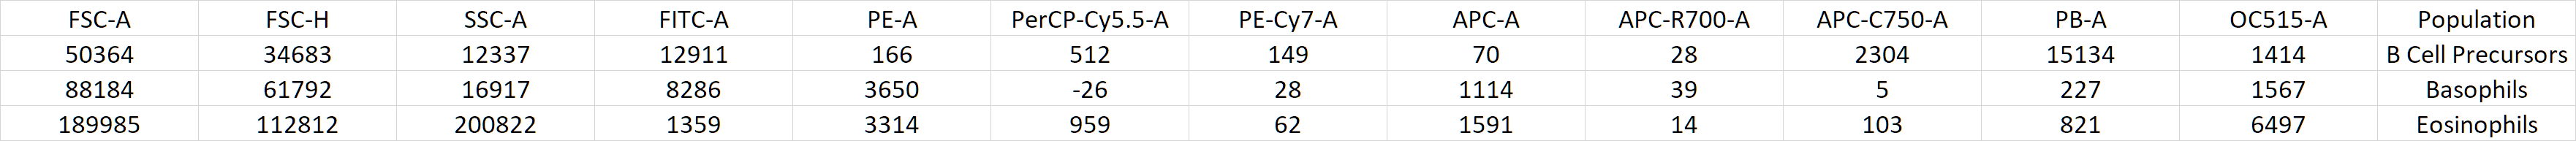

<font color='orange'>**INPUT:** Load the training dataset into a pandas DataFrame. Insert the training dataset name like below:

*dataset_name = 'example.csv'*

In [ ]:
dataset_name = 'Sample_training_dataset.csv'    
data = pd.read_csv(dataset_name) 

### Training and validation steps

Split the dataset into 80% training and 20% validation sets (test_size=0.2, customizable). The "Population" is the column with annotations.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Population', 'FSC-H'], axis=1),
                                                    data['Population'],
                                                    test_size=0.2,
                                                    random_state=42)

Define the parameter grid for hyperparameter optimization (customizable, directly impacts the computation time).

In [ ]:
param_grid = {'n_estimators': [20],
              'criterion': ['gini', 'entropy', 'log_loss'],
              'min_samples_split': [2, 5],
              'min_samples_leaf': [1, 2],
              'max_features': ['sqrt', 'log2', None],
              'bootstrap': [False],
              'n_jobs': [-1],
              'warm_start': [True],
              'random_state': [42]}

Perform the grid search and train the model to data with 3-fold cross validation (customizable, directly impacts the computation time).

In [ ]:
model = GridSearchCV(RandomForestClassifier(),
                     param_grid,
                     verbose=0,
                     scoring='accuracy',
                     cv=3)
model.fit(X_train, y_train)

Predict the validation set and view the best parameters and a classification report as an evaluation of the model.

In [ ]:
predictions = model.predict(X_test)
print(model.best_params_)
print(classification_report(y_test, predictions))

<font color='orange'>**INPUT:** Save the model into an object for future use. Insert the model name like below:

*model_name = 'example.pkl'*

In [ ]:
model_name = ''  
pickle.dump(model, open(model_name, 'wb'))

### Test step

A function for analyzing test FCS files, saving a table of percentages populations present, and saving desired figures. Please read the comment at line 29.

In [ ]:
def analyze(address, ml_model, dotplot_num, dotplot_params):
    file_address = address
    global file_name
    file_name = file_address.replace('.fcs', '')
    fcs_file = flowio.FlowData(file_address)
    try:
        spill, markers = flowutils.compensate.get_spill(fcs_file.text['spill'])
    except KeyError:
        spill, markers = flowutils.compensate.get_spill(fcs_file.text['spillover'])
    raw_data = np.reshape(fcs_file.events, (-1, fcs_file.channel_count))
    fluoro_indices = []
    for channel in fcs_file.channels:
        if fcs_file.channels[channel]['PnN'] in markers:
            fluoro_indices.append(int(channel) - 1)
    fluoro_indices.sort()
    comp_data = flowutils.compensate.compensate(raw_data, spill, fluoro_indices)
    channel_list = []
    for i in range(1, fcs_file.channel_count + 1):
        channel_list.append(fcs_file.text['p{}n'.format(i)])
    flow_data = FlowCal.transform.to_rfi(comp_data, amplification_type=(tuple([(0, 0)] * len(channel_list))))
    events = pd.DataFrame(flow_data, columns=channel_list)
    total_events = events.loc[events['FSC-A'] / events['FSC-H'] < 2]
    for ch in ['FSC-H', 'SSC-H', 'Time']:
        try:
            total_events.drop(columns=[ch], inplace=True)
        except KeyError:
            pass
    model = ml_model
    # If you want to test the sample files (csv and fcs), to match the columns between the training dataset and sample fcs,
    # run the the next line of code as well (remove # from the beginning).
    # total_events = total_events[['FSC-A', 'SSC-A', 'FITC-A', 'PE-A', 'PerCP-Cy5.5-A', 'PE-Cy7-A', 'APC-A', 'APC-R700-A', 'APC-Cy7-A', 'V450-A', 'V500-C-A']]
    total_events['Predicted'] = model.predict(total_events)
    global wbc_events
    wbc_events = total_events.loc[(total_events['Predicted'] != 'Erythroid Cells') & (total_events['Predicted'] != 'Erythroid Precursors')]
    results = wbc_events['Predicted'].value_counts(normalize=True) * 100
    results.to_csv('{} results.csv'.format(file_name))
    global mrd_events
    mrd_events = wbc_events.loc[wbc_events['Predicted'] == 'Residual Leukemic Cells']
    for n in range(dotplot_num):
        dot_plot(dotplot_params[n][0], dotplot_params[n][1])

A function for creating and saving figures showing the MRD population based on your parameters of choice.

In [ ]:
def dot_plot(x, y):
    sns.scatterplot(x=wbc_events[x], y=wbc_events[y], c='lightgrey', s=1)
    sns.scatterplot(x=mrd_events[x], y=mrd_events[y], c='maroon', s=3)
    if x in ['FSC-A', 'SSC-A']:
        plt.xscale('linear')
    else:
        plt.xscale('symlog', linthresh=1000)
        plt.xlim(left=-1000)
    if y in ['FSC-A', 'SSC-A']:
        plt.yscale('linear')
    else:
        plt.yscale('symlog', linthresh=1000)
        plt.ylim(bottom=-1000)
    plt.savefig('{}-{}-{}.png'.format(file_name, x, y))
    plt.close()

<font color='orange'>**INPUT:** Load the model from a saved pickle object. Insert the model name like below:

*model_name = 'example.pkl'*

In [ ]:
model_name = '' 
model = pickle.load(open(model_name, 'rb'))

<font color='orange'>**INPUT:** Analyze a single fcs file. Add the name of the file, indicate the number of figures you want and the parameters in figures like below:

*file_name = 'example.fcs'*

*fig_num = 2*

*fig_params = [('FSC-A', 'SSC-A'), ('PE-A', 'APC-A')]*

In [ ]:
file_name = ''
fig_num = 0
fig_params = []
analyze(file_name, model, fig_num, fig_params)